_______-

In [1]:
import os
import os.path as osp
import time

from collections import OrderedDict

from tqdm import *
import numpy as np

import theano
import theano.tensor as T
import lasagne

%matplotlib inline
import matplotlib.pyplot as plt

### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnisty as mnist

#### Utils

In [2]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]



## Datasets

In [3]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [4]:
X_inv, y_inv = mnist.load_mnist(dataset='training', path='mnist/')
X_inv = 1.-X_inv.reshape(-1, 1, 28, 28).astype('float32')

X_inv_test, y_inv_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_inv_test = 1.-X_inv_test.reshape(-1, 1, 28, 28).astype('float32')

In [5]:
def one_hot(y, n_classes=10):
    onehot = np.zeros(shape=(y.shape[0], n_classes), dtype='float32')

    onehot[np.arange(y.shape[0]), y] = 1
    return onehot

y = one_hot(y).astype('int32')
y_test = one_hot(y_test).astype('int32')

y_inv = one_hot(y_inv).astype('int32')
y_inv_test = one_hot(y_inv_test).astype('int32')

In [6]:
X_train = X[:50000]
X_val = X[50000:]

y_train = y[:50000]
y_val = y[50000:]


In [7]:
X_inv_train = X_inv[:50000]
X_inv_val = X_inv[50000:]

y_inv_train = y_inv[:50000]
y_inv_val = y_inv[50000:]


In [8]:
# dataset domain - 

X_dom_train = np.concatenate((X_train, X_inv_train))
X_dom_val = np.concatenate((X_val, X_inv_val))

y_dom_train = np.concatenate(([1]*X_train.shape[0],[0]*X_inv_train.shape[0] )).astype('int32')
y_dom_val = np.concatenate(([1]*X_val.shape[0],[0]*X_inv_val.shape[0] )).astype('int32')

In [9]:
X[0][0].max(), X_inv[0][0].max()

(1.0, 1.0)

_____

### Usual vgg like arch for classification

In [9]:
img_shape = (None, 1, 28, 28)

input_img = T.tensor4('x_image')
target_y = T.matrix("target", dtype='int32')

In [13]:
nnet = OrderedDict()
nnet['input'] = lasagne.layers.InputLayer(img_shape, input_img)
nnet['conv_11'] = lasagne.layers.Conv2DLayer(nnet[nnet.keys()[-1]], 8, 2)
nnet['conv_12'] = lasagne.layers.Conv2DLayer(nnet[nnet.keys()[-1]], 8, 2)
nnet['pool_1'] = lasagne.layers.Pool2DLayer(nnet[nnet.keys()[-1]], 2)
print (nnet.keys()[-1], nnet[nnet.keys()[-1]].output_shape)

nnet['conv_21'] = lasagne.layers.Conv2DLayer(nnet[nnet.keys()[-1]], 16, 2)
nnet['conv_22'] = lasagne.layers.Conv2DLayer(nnet[nnet.keys()[-1]], 16, 2)
nnet['pool_2'] = lasagne.layers.Pool2DLayer(nnet[nnet.keys()[-1]], 2)
print (nnet.keys()[-1], nnet[nnet.keys()[-1]].output_shape)

nnet['conv_31'] = lasagne.layers.Conv2DLayer(nnet[nnet.keys()[-1]], 32, 2)
nnet['conv_32'] = lasagne.layers.Conv2DLayer(nnet[nnet.keys()[-1]], 32, 2)
nnet['pool_3'] = lasagne.layers.Pool2DLayer(nnet[nnet.keys()[-1]], 2)
print (nnet.keys()[-1], nnet[nnet.keys()[-1]].output_shape)

nnet['dense_1'] = lasagne.layers.DenseLayer(nnet[nnet.keys()[-1]], 100)
nnet['dense_2'] = lasagne.layers.DenseLayer(nnet[nnet.keys()[-1]], y.shape[1], 
                                            nonlinearity=lasagne.nonlinearities.softmax)

nnet_output = nnet[nnet.keys()[-1]]

('pool_1', (None, 8, 13, 13))
('pool_2', (None, 16, 5, 5))
('pool_3', (None, 32, 1, 1))


In [14]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(nnet_output)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(nnet_output,trainable=True)
print all_weights

[W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b]


/home/amir/git_downloads/docker-jupyter-keras-tools/src/lasagne/lasagne/layers/pool.py:267: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/amir/git_downloads/docker-jupyter-keras-tools/src/lasagne/lasagne/layers/pool.py:267: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/amir/git_downloads/docker-jupyter-keras-tools/src/lasagne/lasagne/layers/pool.py:267: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [15]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean() 

In [16]:
#prediction accuracy (WITH dropout)
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adamax(loss, all_weights, learning_rate=0.005)

In [17]:
#function that computes loss and updates weights
train_fun = theano.function([input_img, target_y],[loss, accuracy], updates = updates_sgd)
#function that computes loss and updates weights
val_fun = theano.function([input_img, target_y], [loss, accuracy])

In [18]:
pred_fun = theano.function([input_img], y_predicted)

In [22]:
with open('some_file_for_output.txt', 'r') as f:
    for i in f.readlines():
        print i



  go! 



  Epoch 1 of 50 took 1818.059s

  training loss (in-iteration):		0.494242

  train accuracy:		84.30 %

  validation loss (in-iteration):		0.188630

  validation accuracy:		94.43 %

  Epoch 2 of 50 took 1799.743s

  training loss (in-iteration):		0.171911

  train accuracy:		94.68 %

  validation loss (in-iteration):		0.124711

  validation accuracy:		96.28 %

  Epoch 3 of 50 took 1798.215s

  training loss (in-iteration):		0.129977

  train accuracy:		96.04 %

  validation loss (in-iteration):		0.111339

  validation accuracy:		96.79 %

  Epoch 4 of 50 took 1799.643s

  training loss (in-iteration):		0.106991

  train accuracy:		96.79 %

  validation loss (in-iteration):		0.099906

  validation accuracy:		97.03 %

  Epoch 5 of 50 took 1797.478s

  training loss (in-iteration):		0.092860

  train accuracy:		97.13 %

  validation loss (in-iteration):		0.096204

  validation accuracy:		97.05 %


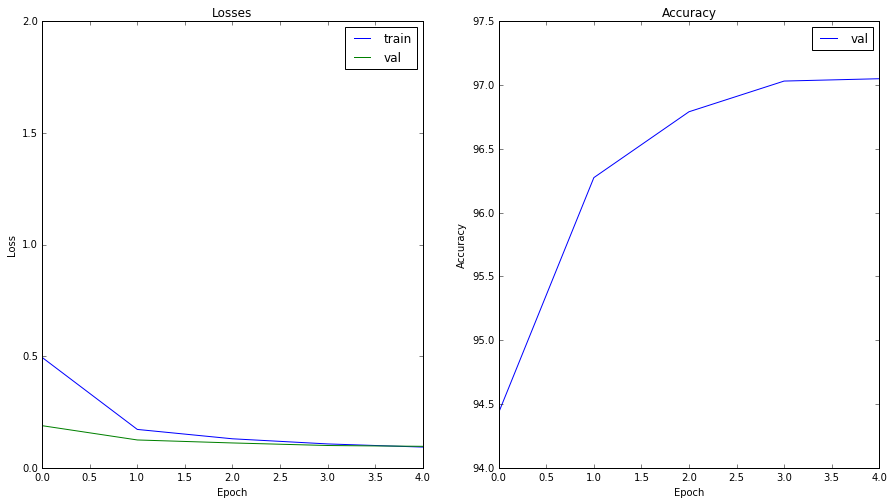

In [20]:
eps = np.arange(len(train_loss_))

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylim((0, 2))
plt.ylabel('Loss')
plt.plot(eps, train_loss_, label='train')
plt.plot(eps, val_loss_, label='val')
plt.legend(loc=0)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(eps, val_acc_, label='val')
plt.legend(loc=0)

# plt.savefig('./some_picture.png')

>> на тесте

In [33]:
some_preds = pred_fun(X_test[:1000])

In [34]:
np.sum(np.argmax(y_test[:1000], axis=1) == np.argmax(some_preds, axis=1)) * 1.0 / len(np.argmax(some_preds, axis=1))

0.97099999999999997

>> на тесте другого датасета

In [35]:
some_preds = pred_fun(X_inv[:1000])

In [36]:
np.sum(np.argmax(y_inv[:1000], axis=1) == np.argmax(some_preds, axis=1)) * 1.0 / len(np.argmax(some_preds, axis=1))

0.16900000000000001

In [37]:
#saving
np.savez('model_cnn_mnist1.npz', *lasagne.layers.get_all_param_values(nnet['dense_2']))

In [38]:
!ls -la

итого 204
drwxrwxr-x 4 amir amir   4096 дек  5 23:35 .
drwxrwxr-x 9 amir amir   4096 дек  5 19:57 ..
-rw-rw-r-- 1 amir amir 118688 дек  5 23:34 Domain_adaptation.ipynb
drwxr-xr-x 2 amir amir   4096 дек  5 20:06 .ipynb_checkpoints
drwxrwxr-x 2 amir amir   4096 дек  5 19:59 mnist
-rw-rw-r-- 1 amir amir   4874 дек  5 19:58 mnisty.py
-rw-rw-r-- 1 amir amir   4925 дек  5 19:58 mnisty.pyc
-rw-rw-r-- 1 amir amir  52378 дек  5 23:35 model_cnn_mnist1.npz
-rw-rw-r-- 1 amir amir    888 дек  5 23:15 some_file_for_output.txt


#And load them again later on like this:
with np.load('model_1.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(nn, param_values)

-------
_______

_______

### Domain Adaptation by Ganin, Lempitsky

https://arxiv.org/pdf/1409.7495.pdf

![](https://i.stack.imgur.com/akoSm.png)

____

In [210]:
img_shape = (None, 1, 28, 28)

input_img = T.tensor4('X_image')
# target_y = T.vector("target_class", dtype='int32')
target_y = T.matrix("target", dtype='int32')
target_domain = T.vector("target_domain", dtype='int32')

In [211]:
da_nnet = OrderedDict()
da_nnet['input'] = lasagne.layers.InputLayer(img_shape, input_img)
da_nnet['conv_11'] = lasagne.layers.Conv2DLayer(da_nnet[da_nnet.keys()[-1]], 4, 2, name='conv_11')
da_nnet['conv_12'] = lasagne.layers.Conv2DLayer(da_nnet[da_nnet.keys()[-1]], 8, 2, name='conv_12')
da_nnet['pool_1'] = lasagne.layers.Pool2DLayer(da_nnet[da_nnet.keys()[-1]], 2, name='pool_1')
print (da_nnet.keys()[-1], da_nnet[da_nnet.keys()[-1]].output_shape)

da_nnet['conv_21'] = lasagne.layers.Conv2DLayer(da_nnet[da_nnet.keys()[-1]], 16, 2, name='conv_21')
da_nnet['conv_22'] = lasagne.layers.Conv2DLayer(da_nnet[da_nnet.keys()[-1]], 32, 2, name='conv_22')
da_nnet['pool_2'] = lasagne.layers.Pool2DLayer(da_nnet[da_nnet.keys()[-1]], 2, name='pool_2')
print (da_nnet.keys()[-1], da_nnet[da_nnet.keys()[-1]].output_shape)

# da_nnet['conv_31'] = lasagne.layers.Conv2DLayer(da_nnet[da_nnet.keys()[-1]], 32, 2, name='conv_31')
# da_nnet['conv_32'] = lasagne.layers.Conv2DLayer(da_nnet[da_nnet.keys()[-1]], 32, 2, name='conv_32')
# da_nnet['pool_3'] = lasagne.layers.Pool2DLayer(da_nnet[da_nnet.keys()[-1]], 2, name='pool_3')
# print (da_nnet.keys()[-1], da_nnet[da_nnet.keys()[-1]].output_shape)

da_nnet['feature'] = lasagne.layers.DenseLayer(da_nnet[da_nnet.keys()[-1]], 32, name='features')

######

da_nnet['classifier_dense_1'] = lasagne.layers.DenseLayer(da_nnet['feature'], 64, name='clf_dense_1')
da_nnet['classifier_dense_2'] = lasagne.layers.DenseLayer(da_nnet['classifier_dense_1'], 48, name='clf_dense_2')

da_nnet['classifier_ans'] = lasagne.layers.DenseLayer(da_nnet['classifier_dense_2'], y.shape[1], 
                                    nonlinearity=lasagne.nonlinearities.softmax, name='clf_ans')

######

da_nnet['domain_dense_1'] = lasagne.layers.DenseLayer(da_nnet['feature'], 64, name='dom_dense_1')
da_nnet['domain_dense_2'] = lasagne.layers.DenseLayer(da_nnet['domain_dense_1'], 32, name='dom_dense_2')

da_nnet['domain_ans'] = lasagne.layers.DenseLayer(da_nnet['domain_dense_2'], 1, 
                                       nonlinearity=lasagne.nonlinearities.sigmoid, 
                                                                 name='domain_ans')


('pool_1', (None, 8, 13, 13))
('pool_2', (None, 32, 5, 5))


In [212]:
clf_predicted = lasagne.layers.get_output(da_nnet['classifier_ans'])
dom_predicted = lasagne.layers.get_output(da_nnet['domain_ans'])

In [213]:
pred_targ = theano.function([input_img], clf_predicted)

In [214]:
loss_classifier = lasagne.objectives.categorical_crossentropy(clf_predicted, target_y).mean() 
loss_domain = lasagne.objectives.binary_crossentropy(dom_predicted, target_domain).mean() 

In [215]:
clf_weights = lasagne.layers.get_all_params(da_nnet['classifier_ans'], trainable=True)
dom_weights = lasagne.layers.get_all_params(da_nnet['domain_ans'], trainable=True)

In [216]:
net_common_params = set(clf_weights) & set(dom_weights)
###
# Те веса которые с минусом должны быть в бекпропе классификатора
###

In [217]:
lambd = theano.shared(1., name='lambda')

In [218]:
updates_dom_sgd_with_minus = lasagne.updates.adamax( - lambd * loss_domain, list(net_common_params), 
                                                    learning_rate=0.005)

In [219]:
updates_dom_sgd = updates_dom_sgd_with_minus.update(lasagne.updates.adamax(loss_domain, 
                                            list(set(dom_weights) - net_common_params), 
                                            learning_rate=0.005))

In [220]:
updates_clf_sgd = lasagne.updates.adamax(loss_classifier, clf_weights, learning_rate=0.005)

In [221]:
accuracy_loss = lasagne.objectives.categorical_accuracy(clf_predicted, target_y).mean() 
accuracy_bin_loss = lasagne.objectives.binary_accuracy(dom_predicted, target_domain).mean() 

In [222]:
train_clf_fun = theano.function([input_img, target_y], loss_classifier, updates = updates_clf_sgd)
val_clf_fun = theano.function([input_img, target_y], [loss_classifier, accuracy_loss])

train_dom_fun = theano.function([input_img, target_domain], loss_domain, updates = updates_dom_sgd)
val_dom_fun = theano.function([input_img, target_domain], [loss_domain, accuracy_bin_loss])

In [223]:
### Проверим что все запускается

train_clf_fun(X_train[:110], y_train[:110]), train_dom_fun(X_dom_train[:2], y_dom_train[:2])

(array(2.3030494646592574), array(0.6583121716976166))

_____

In [224]:
import datetime

In [225]:
with open('some_file_for_output1.txt', 'w') as f:
    f.write("\n  start at {}! \n".format(str(datetime.datetime.now())[:19]))
    f.close()

In [ ]:

 
num_epochs = 50 # amount of passes through the data
            
batch_size = 200 # number of samples processed at each function call
print 'starting trainig...'

#train_loss_ = []
val_acc_base_ = []
val_acc_inv_ = []

for epoch in tqdm_notebook(range(num_epochs), leave=False, desc='epoches'):
    
    
    batch_size += 5

    #################
    #   Classifier  #
    #################
    
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in tqdm_notebook(iterate_minibatches(X_train, y_train, batch_size), 
                                total=int(y_train.shape[0] / batch_size), leave=False, 
                                                             desc = 'classifier_training'):
        inputs, targets = batch
        train_err_batch = train_clf_fun(inputs, targets)
        train_err += train_err_batch
        train_batches += 1
        
    print ("\n  training clf loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print ("\n\t\t  {:.3f}s".format(time.time() - start_time))
    
    
    ################
    #  validation  #
    ################
    #
    val_err = 0
    val_acc = 0
    val_batches = 0
    start_time = time.time()
    for batch in tqdm_notebook(iterate_minibatches(X_val, y_val, batch_size), 
                                total=int(y_val.shape[0]/batch_size), leave=False, 
                                       desc = 'classifier_validation_on_base_dataset'):
        inputs, targets = batch
        val_err_batch, val_acc_batch = val_clf_fun(inputs, targets)
        val_err += val_err_batch
        val_acc += val_acc_batch
        val_batches += 1
    print ("\n  validation on base domain dataset:")
    print ("\n\t\t  validation clf loss (in-iteration):\t\t{:.6f}".format(val_err / val_batches))
    print ("\n\t\t  val accuracy (in-iteration):\t\t{:.6f}".format(val_acc / val_batches))
    print ("\n\t\t  {:.3f}s".format(time.time() - start_time))
    
    val_acc_base_.append(val_acc / val_batches)

    
    val_err = 0
    val_acc = 0
    val_batches = 0
    start_time = time.time()
    for batch in tqdm_notebook(iterate_minibatches(X_inv_val, y_inv_val, batch_size), 
                                    total=int(y_inv_val.shape[0]/batch_size), leave=False, 
                                            desc = 'classifier_validation_on_inverse_dataset'):
        inputs, targets = batch
        val_err_batch, val_acc_batch = val_clf_fun(inputs, targets)
        val_err += val_err_batch
        val_acc += val_acc_batch
        val_batches += 1
    print ("\n  validation on inverse dataset:")    
    print ("\n\t\t  validation clf loss (in-iteration):\t\t{:.6f}".format(val_err / val_batches))
    print ("\n\t\t  val accuracy (in-iteration):\t\t{:.6f}".format(val_acc / val_batches))
    print ("\n\t\t  {:.3f}s".format(time.time() - start_time))
    
    val_acc_inv_.append(val_acc / val_batches)
    
    #################
    #  DOMAIN LABEL #
    #################
    
    _train_err = 0
    _train_batches = 0
    start_time = time.time()
    for batch in tqdm_notebook(iterate_minibatches(X_dom_train, y_dom_train, batch_size),
                                    total = int( y_dom_train.shape[0]/batch_size), leave=False, 
                                                    desc = 'domain_label_classification_training'):
        inputs, targets = batch
        train_err_batch = train_dom_fun(inputs, targets)
        _train_err += train_err_batch
        _train_batches += 1
        
    print ("\n  training domain loss (in-iteration):\t\t{:.6f}".format(_train_err / _train_batches))    
    print ("\n\t\t  {:.3f}s".format(time.time() - start_time))
    
    # domain validation 
    _val_err = 0
    _val_acc = 0
    _val_batches = 0
    start_time = time.time()
    for batch in tqdm_notebook(iterate_minibatches(X_dom_val, y_dom_val, batch_size),
                                  total = int(y_dom_val.shape[0]/batch_size), leave=False,
                                                             desc = 'domain_label_validation'):
        inputs, targets = batch
        val_err_batch, val_acc_batch = val_dom_fun(inputs, targets)
        _val_err += train_err_batch
        _val_acc += val_acc_batch
        _val_batches += 1

    print ("\n  validation domain loss (in-iteration):\t\t{:.6f}".format(_val_err / _val_batches))  
    print ("\n\t\t  validation acc (in-iteration):\t\t{:.6f}".format(_val_acc / _val_batches))  
    print ("\n\t\t  {:.3f}s".format(time.time() - start_time))
     
    
    ################
    #  validation  #
    ################
    # Again after domain transfer
    
    val_err = 0
    val_acc = 0
    val_batches = 0
    start_time = time.time()
    for batch in tqdm_notebook(iterate_minibatches(X_val, y_val, batch_size), 
                                total=int(y_val.shape[0] / batch_size), leave=False, 
                                       desc = 'classifier_validation_on_base_dataset'):
        inputs, targets = batch
        val_err_batch, val_acc_batch = val_clf_fun(inputs, targets)
        val_err += val_err_batch
        val_acc += val_acc_batch
        val_batches += 1
    print ("\n  validation on base domain dataset:")
    print ("\n\t\t  validation clf loss (in-iteration):\t\t{:.6f}".format(val_err / val_batches))
    print ("\n\t\t  val accuracy (in-iteration):\t\t{:.6f}".format(val_acc / val_batches))
    print ("\n\t\t  {:.3f}s".format(time.time() - start_time))
    val_acc_base_.append(val_acc / val_batches)
     
    
    val_err = 0
    val_acc = 0
    val_batches = 0
    start_time = time.time()
    for batch in tqdm_notebook(iterate_minibatches(X_inv_val, y_inv_val, batch_size), 
                                    total=int(y_inv_val.shape[0]/batch_size), leave=False, 
                                            desc = 'classifier_validation_on_inverse_dataset'):
        inputs, targets = batch
        val_err_batch, val_acc_batch = val_clf_fun(inputs, targets)
        val_err += val_err_batch
        val_acc += val_acc_batch
        val_batches += 1
    print ("\n  validation on inverse dataset:")    
    print ("\n\t\t  validation clf loss (in-iteration):\t\t{:.6f}".format(val_err / val_batches))
    print ("\n\t\t  val accuracy (in-iteration):\t\t{:.6f}".format(val_acc / val_batches))
    print ("\n\t\t  {:.3f}s".format(time.time() - start_time))
    val_acc_inv_.append(val_acc / val_batches)
    
    lambd *= 0.9
    
#     with open('some_file_for_output1.txt', 'a') as f:
#         f.write("\n  Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
#         f.write("\n  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
#         f.write("\n  validation loss (in-iteration):\t\t{:.6f}".format(_train_err / _train_batches))
#         f.close()

starting trainig...

  training clf loss (in-iteration):		0.389165

		  757.130s

  validation on base domain dataset:

		  validation clf loss (in-iteration):		0.116115

		  val accuracy (in-iteration):		0.966768

		  54.552s

  validation on inverse dataset:

		  validation clf loss (in-iteration):		8.460004

		  val accuracy (in-iteration):		0.051626

		  54.954s

  training domain loss (in-iteration):		1.333369

		  556.107s

  validation domain loss (in-iteration):		1.444543

		  validation acc (in-iteration):		0.500126

		  112.874s

  validation on base domain dataset:

		  validation clf loss (in-iteration):		0.115595

		  val accuracy (in-iteration):		0.966972

		  55.747s

  validation on inverse dataset:

		  validation clf loss (in-iteration):		8.459207

		  val accuracy (in-iteration):		0.052439

		  54.172s

  training clf loss (in-iteration):		0.104407

		  776.175s

  validation on base domain dataset:

		  validation clf loss (in-iteration):		0.081459

		  val accuracy

In [ ]:
plt.plot(val_acc_base_)

In [ ]:
plt.plot(val_acc_inv_)

> Изменить порядок тренировки - сначала домейн, потом классификатор ??? чтобы не ломалось?

In [ ]:
np.log(10) == 2.3025850929940459

In [ ]:
pred_targ(X_dom_val[-10:])